<a href="https://colab.research.google.com/github/Raanjeetsgolu/Imdb-movie-sentiment-analysis-Deep-Learning/blob/main/Imdb_movie_sentiment_analysis_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Plan of Action


1.   Load **IMDb Movie Reviews dataset (50,000 reviews)**
2.   **Pre-process dataset** by removing special characters, numbers, etc. from user reviews + convert **sentiment labels** positive & negative to numbers 1 & 0, respectively
3.   **Import GloVe Word Embedding** to build Embedding Dictionary + Use this to build Embedding Matrix for our Corpus
4. Model Training using **Deep Learning in Keras** for separate: **Simple Neural Net, CNN and LSTM Models** and analyse model performance and results
4. Last, perform **predictions on real IMDb movie reviews**

## Downloading the Movie Dataset and GloVe Word Embedding





In [1]:
#Downloading the imdb movie dataset from kaggle

!kaggle datasets download -d 'lakshmi25npathi/imdb-dataset-of-50k-movie-reviews'

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 35% 9.00M/25.7M [00:00<00:00, 73.7MB/s]
100% 25.7M/25.7M [00:00<00:00, 141MB/s] 


In [2]:
#unzipping the imdb movie dataset and renaming the file

! unzip '/content/imdb-dataset-of-50k-movie-reviews.zip'  && mv '/content/IMDB Dataset.csv' '/content/IMDB_Dataset.csv'

Archive:  /content/imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [3]:
#Downloading the GloVe Word Embedding

! kaggle datasets download -d danielwillgeorge/glove6b100dtxt

Dataset URL: https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt
License(s): unknown
 97% 127M/131M [00:00<00:00, 193MB/s]
100% 131M/131M [00:00<00:00, 184MB/s]


In [4]:
# We need to extract only the file(s) containing 100d data from the zip archive. This archive includes multiple files"
# unzipping the Glove Word Embedding zip file

! unzip   /content/glove6b100dtxt.zip


Archive:  /content/glove6b100dtxt.zip
  inflating: glove.6B.100d.txt       


### Importing the essential libraries and fuction

In [5]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.models import Sequential
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM

from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Loading dataset

In [6]:
# Importing IMDb Movie review  dataset

imdb_movie_reviews = pd.read_csv("IMDB_Dataset.csv")


In [7]:
# Dataset exploration

imdb_movie_reviews.shape

(50000, 2)

In [8]:
imdb_movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [9]:
# Checking for missing values

imdb_movie_reviews.isnull().sum()

review       0
sentiment    0
dtype: int64

<ipython-input-10-30ebfcc5bf2f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment' , hue=None, legend=False, data=imdb_movie_reviews, palette=['green', 'grey']);


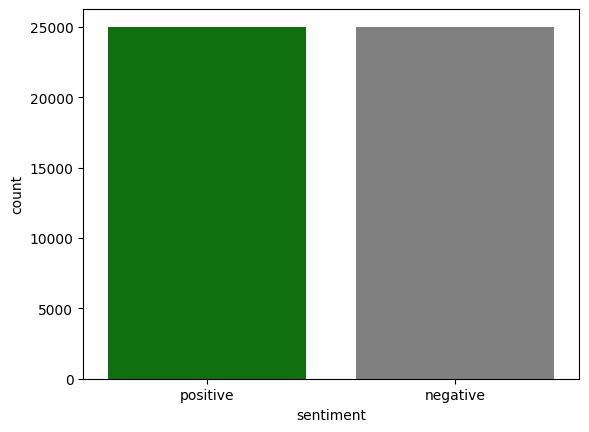

In [10]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment' , hue=None, legend=False, data=imdb_movie_reviews, palette=['green', 'grey']);


## Data Preprocessing

In [11]:
imdb_movie_reviews["review"][0]


"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [ ]:
# In our text, we observe the presence of punctuation marks, brackets, HTML tags, and numerical values.
# In the upcoming section, we'll proceed to preprocess this text.

In [12]:
# For remove HTML tgas
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [13]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # For removing HTML tags
    sentence = remove_tags(sentence)

    # For removing punctuations
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # For single  character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # For remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # For removing Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [14]:
# Calling preprocessing_text function on imdb_movie_reviews

X = []
sentences = list(imdb_movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [15]:
# Sample cleaned up movie review

X[0]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

'one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street skill

In [16]:
# Converting sentiment labels to 0 & 1

y = imdb_movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=28)

# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs

## Preparing embedding layer

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [18]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [19]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92302

In [20]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [21]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/glove.6B.100d.txt', encoding="utf8")


for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()




In [22]:
import numpy as np
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r', encoding='utf8')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.asarray(splitLine[1:], dtype='float32')
        model[word] = embedding
    # print("Done.",len(model)," words loaded!"
    return model


In [23]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [29]:
embedding_matrix.shape

(92302, 100)

# Model Training with:

## Simple Neural Network

In [30]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
snn_model.add(embedding_layer)
snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [31]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9230200   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9240201 (35.25 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 9230200 (35.21 MB)
_________________________________________________________________
None


In [32]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 7s 7ms/step - loss: 0.5544 - acc: 0.7158 - val_loss: 0.5217 - val_acc: 0.7465
Epoch 2/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4470 - acc: 0.7956 - val_loss: 0.5220 - val_acc: 0.7551
Epoch 3/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4116 - acc: 0.8146 - val_loss: 0.5144 - val_acc: 0.7592
Epoch 4/6
250/250 [==============================] - 1s 3ms/step - loss: 0.3896 - acc: 0.8279 - val_loss: 0.5349 - val_acc: 0.7527
Epoch 5/6
250/250 [==============================] - 1s 3ms/step - loss: 0.3731 - acc: 0.8349 - val_loss: 0.5411 - val_acc: 0.7550
Epoch 6/6
250/250 [==============================] - 1s 3ms/step - loss: 0.3601 - acc: 0.8429 - val_loss: 0.5501 - val_acc: 0.7508


In [33]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 0.5470 - acc: 0.7506


In [34]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5470329523086548
Test Accuracy: 0.7505999803543091


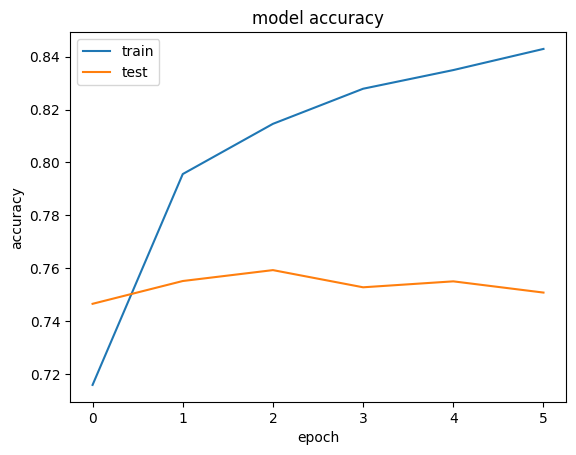

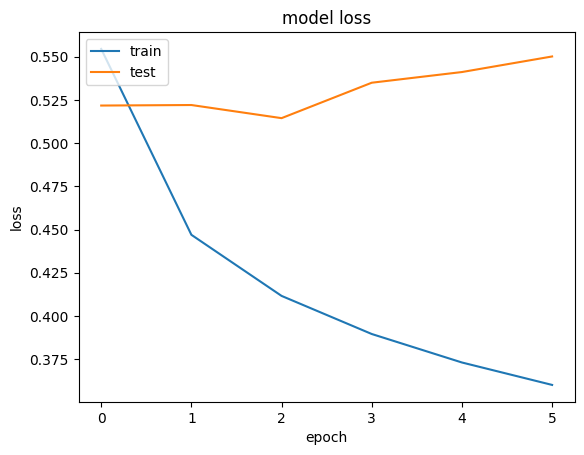

In [35]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Convolutional Neural Network

In [36]:
from keras.layers import Conv1D

In [37]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [38]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9230200   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9294457 (35.46 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9230200 (35.21 MB)
_________________________________________________________________
None


In [39]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
250/250 [==============================] - 5s 6ms/step - loss: 0.4668 - acc: 0.7733 - val_loss: 0.3866 - val_acc: 0.8288
Epoch 2/5
250/250 [==============================] - 1s 4ms/step - loss: 0.3339 - acc: 0.8593 - val_loss: 0.3624 - val_acc: 0.8389
Epoch 3/5
250/250 [==============================] - 1s 4ms/step - loss: 0.2789 - acc: 0.8883 - val_loss: 0.3459 - val_acc: 0.8485
Epoch 4/5
250/250 [==============================] - 1s 4ms/step - loss: 0.2348 - acc: 0.9120 - val_loss: 0.3421 - val_acc: 0.8501
Epoch 5/5
250/250 [==============================] - 1s 4ms/step - loss: 0.1989 - acc: 0.9307 - val_loss: 0.3459 - val_acc: 0.8503


In [40]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.3355 - acc: 0.8535


In [41]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.33550670742988586
Test Accuracy: 0.8535000085830688


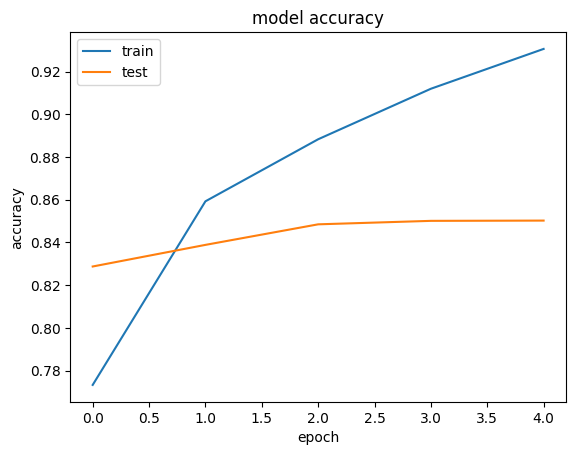

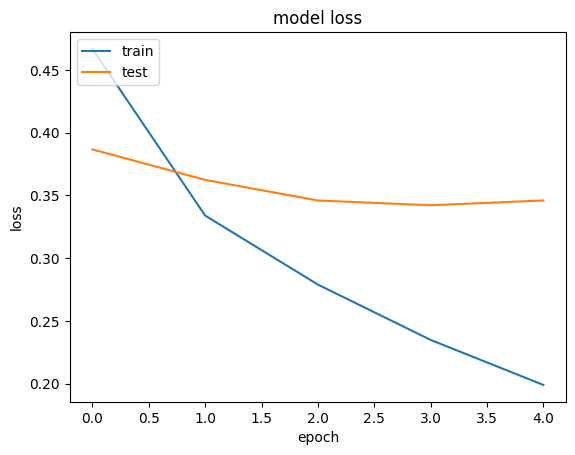

In [42]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Recurrent Neural Network (LSTM)

In [24]:
from keras.layers import LSTM

In [25]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [26]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9230200   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 9347577 (35.66 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9230200 (35.21 MB)
_________________________________________________________________
None


In [27]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 79s 302ms/step - loss: 0.5251 - acc: 0.7426 - val_loss: 0.5004 - val_acc: 0.7582
Epoch 2/6
250/250 [==============================] - 75s 299ms/step - loss: 0.4218 - acc: 0.8100 - val_loss: 0.4065 - val_acc: 0.8280
Epoch 3/6
250/250 [==============================] - 77s 309ms/step - loss: 0.3702 - acc: 0.8381 - val_loss: 0.3713 - val_acc: 0.8424
Epoch 4/6
250/250 [==============================] - 74s 296ms/step - loss: 0.3435 - acc: 0.8536 - val_loss: 0.3522 - val_acc: 0.8480
Epoch 5/6
250/250 [==============================] - 78s 311ms/step - loss: 0.3205 - acc: 0.8645 - val_loss: 0.3353 - val_acc: 0.8656
Epoch 6/6
250/250 [==============================] - 75s 302ms/step - loss: 0.3019 - acc: 0.8747 - val_loss: 0.3243 - val_acc: 0.8615


In [28]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 16s 52ms/step - loss: 0.3201 - acc: 0.8624


In [29]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3201376497745514
Test Accuracy: 0.8623999953269958


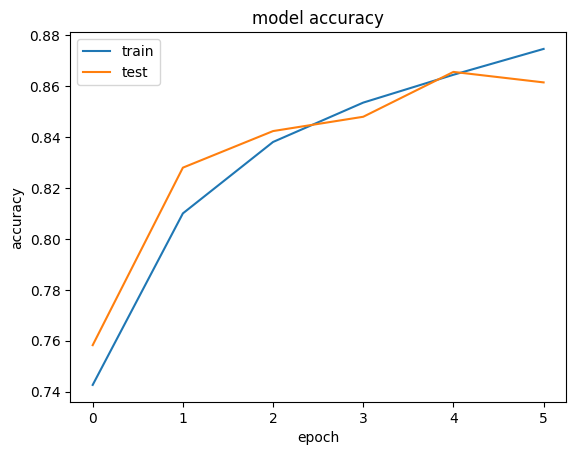

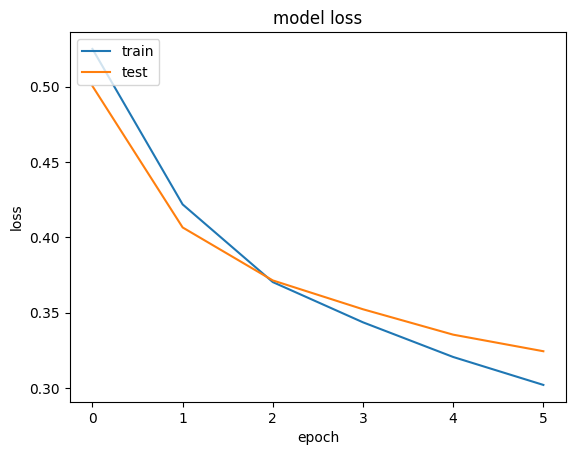

In [30]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [31]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Making Predictions on Live IMDb data

In [38]:
!kaggle datasets download -d meetranjeet/imdb-unseen-dataset-csv

403 - Forbidden - Permission 'datasets.get' was denied


In [32]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv("/content/a3_IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [33]:
sample_reviews.shape


(6, 4)

In [34]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [35]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [36]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 1s 685ms/step


array([[0.65475005],
       [0.98993146],
       [0.18823606],
       [0.16959628],
       [0.9801779 ],
       [0.02248005]], dtype=float32)

In [37]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,6.5
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,1.9
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,1.7
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.8
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.2
